# Try quadratic cost function
Supposed to penalize power AND Energy instead of only energy!

In [ ]:
import sys
import os


# Make sure the root or 03_optimization folder is in the path
sys.path.append(os.path.abspath('../'))   # adjust path if needed
sys.path.append(os.path.abspath('../..'))   # adjust path if needed
#print (sys.path)
print("Current Python Path:", sys.path)

Current Python Path: ['/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/srv/fh6281/GermanBuildingDate/venv/lib/python3.10/site-packages', '/srv/fh6281/GermanBuildingDate/03_optimization', '/srv/fh6281/GermanBuildingDate']


In [2]:
from optimization.base import BaseOptimizer
from utils import simpsons_rule, cdf_formula, pdf_formula, cdf_formula_numpy, pdf_formula_numpy, dynamic_bounds
from input_manager.price_manager import PriceManager

import pandas as pd
import numpy as np
import pyomo.environ as pyo
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import plotly.graph_objects as go

import matplotlib.dates as mdates
import plotly.express as px
from scipy.optimize import fsolve
import numpy as np

In [3]:
def plot_battery_evo(optimizer):

    e_min = list(optimizer.model.e_min.get_values().values())
    e_max = list(optimizer.model.e_max.get_values().values())
    e_exp = list(optimizer.model.e_exp.get_values().values())

    time_e = list(optimizer.model.time_e)
    fig, ax = plt.subplots(figsize=(10, 6)) # 10,6
    ax.plot(time_e, e_min, label='e_min', color='blue', linewidth=2)
    ax.plot(time_e, e_max, label='e_max', color='red', linewidth=2)
    ax.plot(time_e, e_exp, label='e_exp', color='green', linewidth=2)
    ax.set_xlabel('Time')
    ax.set_ylabel('State of Energy (kWh)')

    plt.grid()
    ax.axhline(y=optimizer.cap_min, color='k', linestyle='--', label='Capacity Min')
    ax.axhline(y=optimizer.cap_max, color='k', linestyle='--', label='Capacity Max')
    plt.legend()
    plt.show()


def plot_battery_power(optimizer):

    y_low = list(optimizer.model.y_low.get_values().values())
    y_high = list(optimizer.model.y_high.get_values().values())
    pb_exp = list(optimizer.model.pb_exp.get_values().values())

    # append the last point again
    y_low.append(y_low[-1])
    y_high.append(y_high[-1])
    pb_exp.append(pb_exp[-1])

    time = list(optimizer.model.time)
    time.append(time[-1] + pd.Timedelta(minutes=optimizer.mpc_freq))  # Append the last time point to close the step plot
    fig, ax = plt.subplots(figsize=(10, 6))

    ax.step(time, y_low, label='y_low', color='red', linewidth=2, where='post')
    ax.step(time, y_high, label='y_high', color='blue', linewidth=2, where='post')
    ax.step(time, pb_exp, label='pb_exp', color='green', linewidth=2, where='post')
    ax.set_xlabel('Time')
    ax.set_ylabel('Battery Power (kW)')
    plt.grid()
    ax.axhline(y=optimizer.pb_min, color='k', linestyle='--', label='Power Min')
    ax.axhline(y=optimizer.pb_max, color='k', linestyle='--', label='Power Max')
    plt.legend()
    plt.show()

In [10]:
import time
#from ..base import BaseOptimizer
from utils import simpsons_rule, cdf_formula, pdf_formula, dynamic_bounds, pdf_formula_numpy

import pandas as pd
import numpy as np
import pyomo.environ as pyo


class IntervalOptimizer(BaseOptimizer):


    def __init__(self, battery_cfg: dict, mpc_freq: int, gt_freq: int, prices, objective, building, param_assumption: str = None):
        super().__init__(battery_cfg=battery_cfg, mpc_freq=mpc_freq, gt_freq=gt_freq, prices=prices, objective=objective, building=building, param_assumption=param_assumption) # only necessary if this class has its own init method


        self.cdf = cdf_formula(self.param_assumption)
        self.pdf = pdf_formula(self.param_assumption)
        self.pdf_numpy = pdf_formula_numpy(self.param_assumption)



    def _build_model(self):

        self._define_sets()

        self._define_parameters()

        self._define_decision_variables()

        self._define_constraints()

        self._define_interval_constraints()

        self._define_objective_function()

    
    def _define_sets(self):

        self.model.time = pyo.Set(initialize=self.time_index)
        self.model.time_e = pyo.Set(initialize=self.time_index.append(pd.Index([self.time_index[-1] + self.time_index.freq])))
        self.model.time_e0 = pyo.Set(initialize=self.time_index.to_list()[:1])

    def _define_parameters(self):
        self.model.e0 = pyo.Param(self.model.time_e0, initialize=self.soe_now)  # TODO: self.soe_initial ok?
        self.model.pdf_weights = pyo.Param(self.model.time, initialize=self.pdf_weights, domain=pyo.Any) 

        self.model.dynamic_bound_low = pyo.Param(self.model.time, initialize=self.dynamic_bound_low)  
        self.model.dynamic_bound_high = pyo.Param(self.model.time, initialize=self.dynamic_bound_high)

        # Interval widths
        self.y_width = self._get_interval_width(probabilities_of_interval=[0.25, 0.75])
        if self.y_width is not None:
            self.model.y_width = pyo.Param(self.model.time, initialize=self.y_width, domain=pyo.NonNegativeReals)  # width of the interval [y_low, y_high] for each time step


    def _define_decision_variables(self): 
        # Battery Power
        self.model.pb_exp = pyo.Var(self.model.time, domain=pyo.Reals)
        self.model.y_low = pyo.Var(self.model.time, domain=pyo.Reals)
        self.model.y_high = pyo.Var(self.model.time, domain=pyo.Reals)

        # Battery Energy
        self.model.e_exp = pyo.Var(self.model.time_e, domain=pyo.Reals)
        self.model.e_min = pyo.Var(self.model.time_e, domain=pyo.Reals)
        self.model.e_max = pyo.Var(self.model.time_e, domain=pyo.Reals)

        # Complementary variables
        self.model.y_low_ch = pyo.Var(self.model.time, domain=pyo.NonPositiveReals)
        self.model.y_low_dis = pyo.Var(self.model.time, domain=pyo.NonNegativeReals)
        self.model.y_high_ch = pyo.Var(self.model.time, domain=pyo.NonPositiveReals)
        self.model.y_high_dis = pyo.Var(self.model.time, domain=pyo.NonNegativeReals)
        self.model.pb_exp_ch = pyo.Var(self.model.time, domain=pyo.NonPositiveReals)
        self.model.pb_exp_dis = pyo.Var(self.model.time, domain=pyo.NonNegativeReals)

        # Probabilities of being out of bounds [y_low, y_high]
        self.model.prob_low = pyo.Var(self.model.time, domain=pyo.NonNegativeReals, bounds=(0, 1))
        self.model.prob_high = pyo.Var(self.model.time, domain=pyo.NonNegativeReals, bounds=(0, 1))

        # Expected grid power
        self.model.pg_exp_buy = pyo.Var(self.model.time, domain=pyo.NonNegativeReals)
        self.model.pg_exp_sell = pyo.Var(self.model.time, domain=pyo.NonPositiveReals)


    def _define_constraints(self):
        # Battery Evolution
        def constr_e_min(model, t):
            ''' e_min[t] = e_min[t-1] - y_high_ch[t-1] * dt * eta_ch - y_high_dis[t-1] * dt / eta_dis '''
            if t == model.time_e.first():
                return model.e_min[t] == model.e0[t]
            else:
                t_prev = model.time_e.prev(t)
                return model.e_min[t] == model.e_min[t_prev] - model.y_high_ch[t_prev] * self.t_inc * self.eta_ch - model.y_high_dis[t_prev] * self.t_inc / self.eta_dis
        self.model.constr_e_min = pyo.Constraint(self.model.time_e, rule=constr_e_min)


        def constr_e_max(model, t):
            ''' e_max[t] = e_max[t-1] - y_low_ch[t-1] * dt * eta_ch - y_low_dis[t-1] * dt / eta_dis '''
            if t == model.time_e.first():
                return model.e_max[t] == model.e0[t]
            else:
                t_prev = model.time_e.prev(t)
                return model.e_max[t] == model.e_max[t_prev] - model.y_low_ch[t_prev] * self.t_inc * self.eta_ch - model.y_low_dis[t_prev] * self.t_inc / self.eta_dis
        self.model.constr_e_max = pyo.Constraint(self.model.time_e, rule=constr_e_max)


        def constr_e_exp(model, t):
            ''' e_exp[t] = e_exp[t-1] - pb_exp_ch[t-1] * dt * eta_ch - pb_exp_dis[t-1] * dt / eta_dis '''
            if t == model.time_e.first():
                return model.e_exp[t] == model.e0[t]
            else:
                t_prev = model.time_e.prev(t)
                return model.e_exp[t] == model.e_exp[t_prev] - model.pb_exp_ch[t_prev] * self.t_inc * self.eta_ch - model.pb_exp_dis[t_prev] * self.t_inc / self.eta_dis
        self.model.constr_e_exp = pyo.Constraint(self.model.time_e, rule=constr_e_exp)



        # Battery Limits
        def constr_e_min_limit(model, t):
            ''' e_min[t] >= capacity_min '''
            return model.e_min[t] >= self.cap_min
        self.model.constr_e_min_limit = pyo.Constraint(self.model.time_e, rule=constr_e_min_limit)

        def constr_e_max_limit(model, t):
            ''' e_max[t] <= capacity_max '''
            return model.e_max[t] <= self.cap_max
        self.model.constr_e_max_limit = pyo.Constraint(self.model.time_e, rule=constr_e_max_limit)

        def constr_y_low_limit(model, t):
            ''' y_low[t] >= power_min'''
            return model.y_low[t] >= self.pb_min
        self.model.constr_y_low_limit = pyo.Constraint(self.model.time, rule=constr_y_low_limit)

        def constr_y_high_limit(model, t):
            ''' y_high[t] <= power_max'''
            return model.y_high[t] <= self.pb_max
        self.model.constr_y_high_limit = pyo.Constraint(self.model.time, rule=constr_y_high_limit)



        # Complementary Constraints
        def constr_y_low_split(model, t):
            ''' y_low[t] = y_low_ch[t] + y_low_dis[t] '''
            return model.y_low[t] == model.y_low_ch[t] + model.y_low_dis[t]
        self.model.constr_y_low_split = pyo.Constraint(self.model.time, rule=constr_y_low_split)

        def constr_y_low_relaxation(model, t):
            ''' -1e-8 <= y_low_ch[t] * y_low_dis[t] <= 0 '''
            return pyo.inequality(-1e-8, model.y_low_ch[t] * model.y_low_dis[t], 0)
        self.model.constr_y_low_relaxation = pyo.Constraint(self.model.time, rule=constr_y_low_relaxation)

        def constr_y_high_split(model, t):
            ''' y_high[t] = y_high_ch[t] + y_high_dis[t] '''
            return model.y_high[t] == model.y_high_ch[t] + model.y_high_dis[t]
        self.model.constr_y_high_split = pyo.Constraint(self.model.time, rule=constr_y_high_split)

        def constr_y_high_relaxation(model, t):
            ''' -1e-8 <= y_high_ch[t] * y_high_dis[t] <= 0 '''
            return pyo.inequality(-1e-8, model.y_high_ch[t] * model.y_high_dis[t], 0)
        self.model.constr_y_high_relaxation = pyo.Constraint(self.model.time, rule=constr_y_high_relaxation)

        def constr_pb_exp_split(model, t):
            ''' pb_exp[t] = pb_exp_ch[t] + pb_exp_dis[t] '''
            return model.pb_exp[t] == model.pb_exp_ch[t] + model.pb_exp_dis[t]
        self.model.constr_pb_exp_split = pyo.Constraint(self.model.time, rule=constr_pb_exp_split)

        def constr_pb_exp_relaxation(model, t):
            ''' -1e-8 <= pb_exp_ch[t] * pb_exp_dis[t] <= 0 '''
            return pyo.inequality(-1e-8, model.pb_exp_ch[t] * model.pb_exp_dis[t], 0)
        self.model.constr_pb_exp_relaxation = pyo.Constraint(self.model.time, rule=constr_pb_exp_relaxation)



        # Charging / Discharging Constraints
        def constr_y_low_ch(model, t):
            ''' y_low_ch[t] <= 0 '''
            return model.y_low_ch[t] <= 0
        self.model.constr_y_low_ch = pyo.Constraint(self.model.time, rule=constr_y_low_ch)

        def constr_y_low_dis(model, t):
            ''' y_low_dis[t] >= 0 '''
            return model.y_low_dis[t] >= 0
        self.model.constr_y_low_dis = pyo.Constraint(self.model.time, rule=constr_y_low_dis)

        def constr_y_high_ch(model, t):
            ''' y_high_ch[t] <= 0 '''
            return model.y_high_ch[t] <= 0
        self.model.constr_y_high_ch = pyo.Constraint(self.model.time, rule=constr_y_high_ch)

        def constr_y_high_dis(model, t):
            ''' y_high_dis[t] >= 0 '''
            return model.y_high_dis[t] >= 0
        self.model.constr_y_high_dis = pyo.Constraint(self.model.time, rule=constr_y_high_dis)

        def constr_pb_exp_ch(model, t):
            ''' pb_exp_ch[t] <= 0 '''
            return model.pb_exp_ch[t] <= 0
        self.model.constr_pb_exp_ch = pyo.Constraint(self.model.time, rule=constr_pb_exp_ch)

        def constr_pb_exp_dis(model, t):
            ''' pb_exp_dis[t] >= 0 '''
            return model.pb_exp_dis[t] >= 0
        self.model.constr_pb_exp_dis = pyo.Constraint(self.model.time, rule=constr_pb_exp_dis)


        # Constraints on y_low and y_high
        def constr_y_order(model, t):
            ''' y_low[t] <= y_high[t] '''
            return model.y_low[t] <= model.y_high[t]
        self.model.constr_y_order = pyo.Constraint(self.model.time, rule=constr_y_order)



        # Probabilities of not being fully covered by the battery
        def constr_prob_low(model, t):
            ''' prob_low[t] = CDF[t](y_low[t]) '''
            return model.prob_low[t] == self.cdf(model.y_low[t], *model.pdf_weights[t])
        self.model.constr_prob_low = pyo.Constraint(self.model.time, rule=constr_prob_low)

        def constr_prob_high(model, t):
            ''' prob_high[t] = 1 - CDF[t](y_high[t]) '''
            return model.prob_high[t] == 1 - self.cdf(model.y_high[t], *model.pdf_weights[t])
        self.model.constr_prob_high = pyo.Constraint(self.model.time, rule=constr_prob_high)



        # Expected Powers
        def constr_pb_exp(model, t):
            ''' pb_exp[t] = prob_low[t] * y_low[t] + prob_high[t] * y_high[t] + INTEGRAL[z*pdf(weights[t], z)] bounds=[y_low[t], y_high[t]] '''
            return model.pb_exp[t] == model.prob_low[t] * model.y_low[t] + model.prob_high[t] * model.y_high[t] + simpsons_rule(model.y_low[t], model.y_high[t], n=200, pdf=self.pdf, weights=model.pdf_weights[t], offset=0) # TODO: Adjust parameters
        self.model.constr_pb_exp = pyo.Constraint(self.model.time, rule=constr_pb_exp)


        def constr_pg_exp_sell(model, t):
            ''' pg_exp_sell[t] = INTEGRAL[z*pdf(weights[t], z+y_low[t])] bounds=[-inf, 0]'''  # TODO: Maybe use historical minimum as integration bound? Does that cause issues since the pdf tails might be too long?
            return model.pg_exp_sell[t] == simpsons_rule(model.dynamic_bound_low[t], 0, n=200, pdf=self.pdf, weights=model.pdf_weights[t], offset=model.y_low[t])  # TODO: Code dynamic bounds
        self.model.constr_pg_exp_sell = pyo.Constraint(self.model.time, rule=constr_pg_exp_sell)

        def constr_pg_exp_buy(model, t):
            ''' pg_exp_buy[t] = INTEGRAL[z*pdf(weights[t], z+y_high[t])] bounds=[0, inf]'''  # TODO: Maybe use historical maximum as integration bound? Does that cause issues since the pdf tails might be too long?
            return model.pg_exp_buy[t] == simpsons_rule(0, model.dynamic_bound_high[t], n=200, pdf=self.pdf, weights=model.pdf_weights[t], offset=model.y_high[t])  # TODO: Code dynamic bounds
        self.model.constr_pg_exp_buy = pyo.Constraint(self.model.time, rule=constr_pg_exp_buy)


    def _define_interval_constraints(self):
        ''' Separated interval constraints to allow an easy overwriting in child-classes. '''
        def constr_y_width(model, t):
            ''' y_high[t] - y_low[t] = y_width[t] '''
            return model.y_high[t] - model.y_low[t] == model.y_width[t]
        self.model.constr_y_width = pyo.Constraint(self.model.time, rule=constr_y_width)



    def _define_objective_function(self):

        if self.objective == 'linear':
            def objective(model):
                ''' Minimize the expected costs associated with the grid exchange. To discourage a total discharge
                    of the battery, we reward the expected battery energy at the end of the horizon. '''
                sum_costs = sum(
                    self.c_sell1[t] * model.pg_exp_sell[t]
                    + self.c_buy1[t] * model.pg_exp_buy[t]
                    for t in model.time
                ) 
                #+ c_soe_end * model.e_exp[model.time_e.last()]
                return sum_costs
        elif self.objective == 'quadratic':
            def objective(model):
                ''' Here, costs are associated with with energy volume AND power. '''
                sum_costs = sum(
                    self.c_buy1[t] * model.pg_exp_buy[t]**2 + self.c_buy2[t] * model.pg_exp_buy[t] 
                    + self.c_sell1[t] * model.pg_exp_sell[t]**2 + self.c_sell2[t] * model.pg_exp_sell[t]  # 0.15 €/kWh for low feed in. 
                    for t in model.time
                ) 
                return sum_costs
            
        elif self.objective == 'exponential':
            def objective(model):
                ''' TBD '''
                sum_costs = sum(
                    0.5 * model.pg_exp_buy[t] - self.c_buy1[t] * (1-pyo.exp(-self.c_buy2[t] * model.pg_exp_buy[t]))
                    - self.c_sell1[t] * (1-pyo.exp(+self.c_sell2[t] * model.pg_exp_sell[t])) for t in model.time
                )
                return sum_costs
        else:
            raise ValueError(f"Unknown objective function: {self.objective}. Choose 'linear' or 'quadratic'.")
        self.model.objective = pyo.Objective(rule=objective, sense=pyo.minimize)



    def _get_interval_width(self, probabilities_of_interval: list) -> dict:
        """ Calculate the width of the interval [y_low, y_high] based on the forecasted quantiles in probabilities_of_interval. """

        quantile_values = {}
        samples = np.linspace(-8, 8, 10000)  # TODO: Code dynamic bounds

        for t in self.pdf_weights.keys():
            weights = self.pdf_weights[t]
            quantile_values[t] = {}

            for prob in probabilities_of_interval:
                for i, sample in enumerate(samples):
                    cdf_val = self.cdf(sample, *weights)
                    if cdf_val >= prob:
                        
                        sample_prev = samples[i-1]
                        cdf_val_prev = self.cdf(sample_prev, *weights)

                        # linearly interpolate between sample and the previous sample to get a better approximation
                        quant_val_interpolated = sample_prev + (sample - sample_prev) * (prob - cdf_val_prev) / (cdf_val - cdf_val_prev)
                        quantile_values[t][prob] = quant_val_interpolated
                        break

        # Calculate the width of the forecasted quantiles
        quantile_widths = {}
        for t, values in quantile_values.items():
            quantile_widths[t] = values[probabilities_of_interval[1]] - values[probabilities_of_interval[0]]

        # Calculate the width of the interval [y_low, y_high]
        scale_factor = (self.cap_max - self.cap_min) / sum(quantile_widths.values())
        interval_widths = {t: width * scale_factor for t, width in quantile_widths.items()}
        interval_widths = pd.Series(interval_widths, name='interval_width')
        return interval_widths
        

    

    def optimize(self, t_now: pd.Timestamp, fc_slice: pd.DataFrame) -> dict:

        print("soe_now:", self.soe_now)

        self.fc_slice = fc_slice
        self.fc_slice.index = pd.DatetimeIndex(self.fc_slice.index.get_level_values('timestamp'), freq=str(self.mpc_freq) + 'min')
        self.time_index = fc_slice.index

        self.pdf_weights = fc_slice.apply(lambda row: row.tolist(), axis=1)

        self.lowest_bound = -18.0
        self.highest_bound = 18.0

        self.dynamic_bound_low, self.dynamic_bound_high = dynamic_bounds((self.lowest_bound, self.highest_bound), self.pdf_numpy, self.fc_slice)

        self.c_buy1, self.c_sell1, self.c_buy2, self.c_sell2 = self._get_prices(self.time_index) # cbuy2=csell2=None for linear prices

        self.model = pyo.ConcreteModel()

        self._build_model()

        result = self.solve()

        # Emergency fallback decision
        if result is None:
            fb_decision = self._fallback_decision()  # TODO: This now contains a dict => Map it so that is has pb_low and pb_high in it
            fb_decision["pb_low"] = fb_decision["pb"]
            fb_decision["pb_high"] = fb_decision["pb"]
            fb_decision.pop("pb", None)
            return fb_decision


        pb_low = [pyo.value(self.model.y_low[t]) for t in self.model.time]
        pb_high = [pyo.value(self.model.y_high[t]) for t in self.model.time]

        decision = {
            'pb_low': pb_low[0],
            'pb_high': pb_high[0],
            'solver_ok': True,
            "solver_status": "ok"
        }

        # TODO: Need to log all the results somewhere so that we cann see what the schedule is at a certain time.
        return decision



    def update_soe(self, t_now, decision, gt):
        
        # decision is a dict containing the actions pb_low and pb_high
        pb_low = decision.get('pb_low')
        pb_high = decision.get('pb_high')

        # If gt is lower than pb_low, we execute pb_low
        if gt <= pb_low:
            pb_now = pb_low
        
        # If gt is higher than pb_high, we execute pb_high
        elif gt >= pb_high:
            pb_now = pb_high
        
        # If gt is between pb_low and pb_high, we execute gt 
        else:
            pb_now = gt


        # Update the soe
        if pb_now <= 0:  # Charging
            eta = self.eta_ch
        elif pb_now > 0:  # Discharging
            eta = 1 / self.eta_dis

        pg_now = gt - pb_now  # Grid Power
        #print(f"pb_now: {pb_now}, pg_now: {pg_now}, gt: {gt}, self.gt_inc: {self.gt_inc}")
        soe_new = self.soe_now - pb_now * self.gt_inc * eta

        if round(soe_new, 5) > self.cap_max or round(soe_new, 5) < self.cap_min:
            raise ValueError(f"State of charge out of bounds: {soe_new} kWh. Should be between {self.cap_min} and {self.cap_max} kWh.") 
        
        if soe_new > self.cap_max:
            soe_new = self.cap_max
        if soe_new < self.cap_min:
            soe_new = self.cap_min
        

        self.results_realization[t_now] = {
            'timestamp': t_now,
            'action': pb_now,       # Power setpoint for the battery at t_now
            'pb_low': pb_low,   # Power setpoint for the battery at t_now
            'pb_high': pb_high, # Power setpoint for the battery at t_now
            'pg': pg_now,           # Grid power after applying the action
            'gt': gt,               # Ground truth at t_now
            'soe_now': self.soe_now,  # Current state of energy before applying the action
            'soe_new': soe_new      # New state of energy after applying the action
        }


        self.soe_now = soe_new
        return soe_new

In [11]:
config = {
    "run_name": "Test Experiment",

    "forecasts": {
        "model": "AutoKANHOURLYTEST",
        "fc_creation_time": "2025-07-25T14:18:05+00:00",
        "parametric_assumption": "sum2gaussian",
        "fc_update_freq": 60
    },


    "optimization": {
        "buildings": ["SFH3"],
        "models": ["interval"],
        "start_time": "2020-06-07T06:00:00+00:00",
        "end_time": "2020-05-13T23:00:00+00:00",
        "gt_freq": 1,
        "mpc_update_freq": [60],
        "mpc_horizon": 24,
        "prices": "exponential_prices.csv",
        "objective": "exponential"
    },


    "battery": {
        "capacity_min": 0.0,
        "capacity_max": 8.0,
        "power_min": -4.0,
        "power_max": 4.0,
        "charge_efficiency": 0.95,
        "discharge_efficiency": 0.95,

        "soe_initial": 0.1
    }
}

In [12]:
mpc_freq = config['optimization']['mpc_update_freq'][0]  # Assuming mpc_update_freq is a list with one element
gt_delta = config['optimization']['gt_freq']  # Assuming gt_freq is a single value

start_time = pd.Timestamp(config['optimization']['start_time'])
building = 'SFH4'
fc_full = pd.read_csv('/srv/fh6281/GermanBuildingDate/02_forecast/mount/storage_param_fc/SFH4/2025-08-14_09-03-44/file_fc_parametric_AutoKAN_SFH4_2025-08-14_09-03-44_freq60.csv')
fc_day = fc_full[pd.to_datetime(fc_full['time_fc_created']) == start_time]
fc_day = fc_day.drop(columns=['time_fc_created'])
fc_slice = fc_day.iloc[:config['optimization']['mpc_horizon']].copy()
fc_slice.set_index('timestamp', inplace=True)
#fc_slice = fc_slice[~fc_slice.index.duplicated(keep='first')]
fc_slice.index = pd.DatetimeIndex(fc_slice.index, freq=str(mpc_freq) + 'min')
fc_slice['std1'] = fc_slice['std1'] / 1000
fc_slice['std2'] = fc_slice['std2'] / 1000
fc_slice['mu1'] = fc_slice['mu1'] / 1000
fc_slice['mu2'] = fc_slice['mu2'] / 1000


In [13]:
prices_path = 'exponential_prices.csv'

price_manager = PriceManager(prices_path, full_path=True)  # Assuming the path is correct and the file exists
prices = price_manager.get_prices(mpc_freq)

In [14]:
optimizer = IntervalOptimizer(battery_cfg=config['battery'], mpc_freq=mpc_freq, gt_freq=gt_delta, building=building, objective=config['optimization']['objective'], param_assumption=config['forecasts']['parametric_assumption'], prices=prices)
optimizer.optimize(None, fc_slice=fc_slice)

soe_now: 0.1
Ipopt 3.14.19: max_iter=8000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.19, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:      867
Number of nonzeros in inequality constraint Jacobian.:      434
Number of nonzeros in Lagrangian Hessian.............:      240

Total number of variables............................:      387
                     variables with only lower bounds:       96
                variables with lower and upper bounds:       48
                     variables with only upper bounds:       96
Total number of equality constraints.............

{'pb_low': -0.339724154227121,
 'pb_high': 1.1252480088209053e-06,
 'solver_ok': True,
 'solver_status': 'ok'}

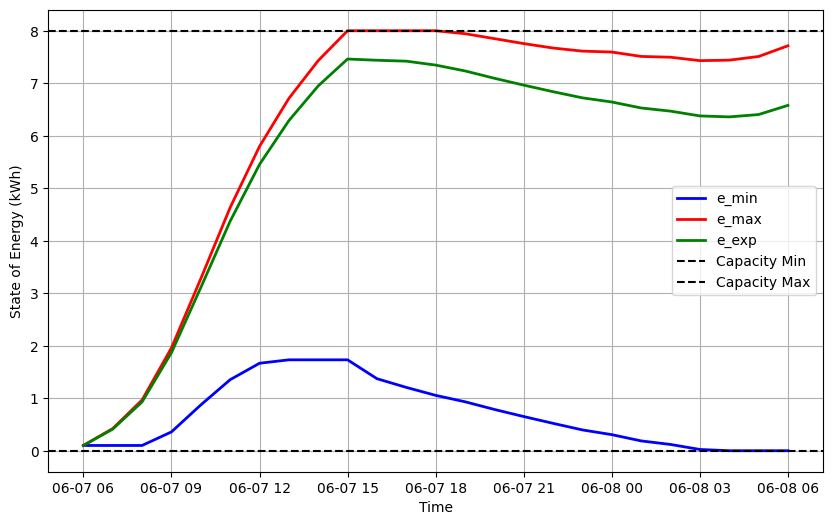

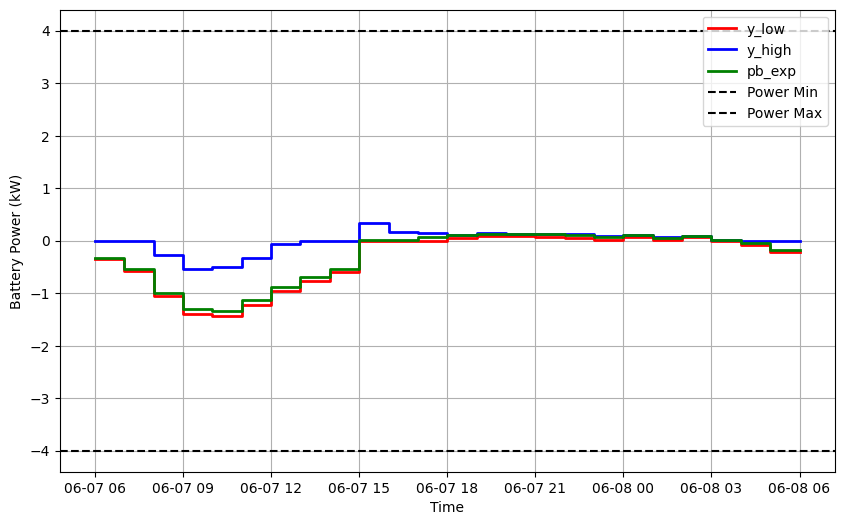

In [15]:
plot_battery_evo(optimizer)
plot_battery_power(optimizer)